## Load packages

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_20108\3818186681.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


### Load dataset

In [3]:
df = pd.read_csv('data_cleaned.csv')

# indicate dummy features
df.iloc[:,19:99] = df.iloc[:,19:99].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 99 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   income_am               4947 non-null   float64 
 1   profit_last_am          4947 non-null   float64 
 2   profit_am               4947 non-null   float64 
 3   damage_am               4947 non-null   float64 
 4   crd_lim_rec             4947 non-null   float64 
 5   cab_requests            4947 non-null   int64   
 6   bar_no                  4947 non-null   int64   
 7   neighbor_income         4947 non-null   float64 
 8   age                     4947 non-null   int64   
 9   tenure_mts              4947 non-null   int64   
 10  tenure_yrs              4947 non-null   int64   
 11  claims_am               4947 non-null   float64 
 12  nights_booked           4947 non-null   int64   
 13  shop_am                 4947 non-null   int64   
 14  outcome_profit          

In [4]:
df = df.drop(['outcome_damage_inc', 'outcome_damage_amount'], axis=1)

relocate outcome_profit to the last column

In [5]:
# Get the column name you want to move to the last column
feature_name = 'outcome_profit'

# Get a list of column names, excluding the feature to move
other_columns = [col for col in df.columns if col != feature_name]

# Reorder the columns so the feature is at the end
new_columns = other_columns + [feature_name]
df = df[new_columns]

## Train test split and standardisation

### Shuffle

In [6]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### Train/test-split

In [7]:
# Import the function
from sklearn.model_selection import train_test_split

# Split of feaures and outcomes
X = df_shuffle.drop(['outcome_profit'],1)
y = df_shuffle['outcome_profit']


# train/split in training and test set
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# train/split in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=4321)

C:\Users\Kelvi\AppData\Local\Temp\ipykernel_20108\440424924.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_profit'],1)


### Standardise

In [8]:

from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_trainval_stand = X_train_val.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()


X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])

X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])

X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

# Polynomial Regression

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=1)
X_train_poly = poly.fit_transform(X_train_stand)
X_val_poly = poly.transform(X_val_stand)
X_train_poly.shape

(3165, 97)

## Penalisation

prevent polynomial regression to overfit (curse of dimensionality)

In [10]:
from sklearn import linear_model

linreg_lasso1 = linear_model.Lasso()
linreg_lasso1.fit(X_train_poly, y_train)
print('R2: %.3f' % linreg_lasso1.score(X_train_poly, y_train))
print('R2: %.3f' % linreg_lasso1.score(X_val_poly, y_val))

R2: 0.365
R2: 0.355


crossvalidation

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

Alpha = np.logspace(-3,1)
print(Alpha)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for a in Alpha:
    lasso = linear_model.Lasso(a, max_iter=3000)
    scores = cross_val_score(lasso, X_train_poly, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))
 
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

train = linear_model.Lasso(Alpha[max_index], max_iter=3000)
train.fit(X_train_poly,y_train)

[1.00000000e-03 1.20679264e-03 1.45634848e-03 1.75751062e-03
 2.12095089e-03 2.55954792e-03 3.08884360e-03 3.72759372e-03
 4.49843267e-03 5.42867544e-03 6.55128557e-03 7.90604321e-03
 9.54095476e-03 1.15139540e-02 1.38949549e-02 1.67683294e-02
 2.02358965e-02 2.44205309e-02 2.94705170e-02 3.55648031e-02
 4.29193426e-02 5.17947468e-02 6.25055193e-02 7.54312006e-02
 9.10298178e-02 1.09854114e-01 1.32571137e-01 1.59985872e-01
 1.93069773e-01 2.32995181e-01 2.81176870e-01 3.39322177e-01
 4.09491506e-01 4.94171336e-01 5.96362332e-01 7.19685673e-01
 8.68511374e-01 1.04811313e+00 1.26485522e+00 1.52641797e+00
 1.84206997e+00 2.22299648e+00 2.68269580e+00 3.23745754e+00
 3.90693994e+00 4.71486636e+00 5.68986603e+00 6.86648845e+00
 8.28642773e+00 1.00000000e+01]


c:\Users\Kelvi\.virtualenvs\SchoolProject-9xAPnXNv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e+09, tolerance: 4.361e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Kelvi\.virtualenvs\SchoolProject-9xAPnXNv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.160e+09, tolerance: 4.107e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\Kelvi\.virtualenvs\SchoolProject-9xAPnXNv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the fe

Lasso(alpha=4.714866363457389, max_iter=3000)

The optimal alpha is 4.714866363457389
The training score of the optimal alpha is 0.3503634203688104
The validation score of the optimal alpha is 0.3052777532702594


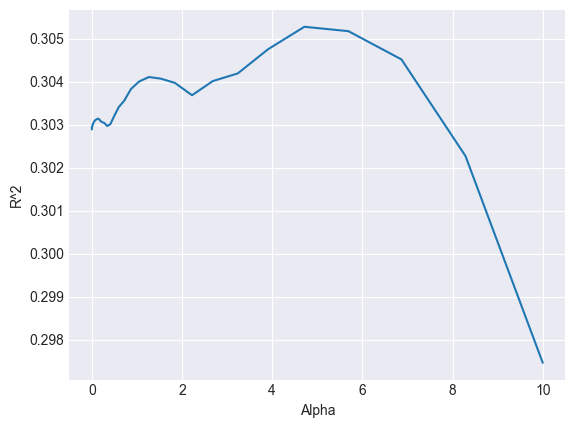

In [14]:
plt.plot(Alpha, cv_scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')

print('The optimal alpha is', Alpha[max_index])
print('The training score of the optimal alpha is', train.score(X_train_poly,y_train))
print('The validation score of the optimal alpha is', max_value)

plt.show()

### Polynomial regression

In [94]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_poly, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.002065768023697201
Order 1: avg R^2 = -2.3788066200948799e+24
Order 2: avg R^2 = -319.59339909618046


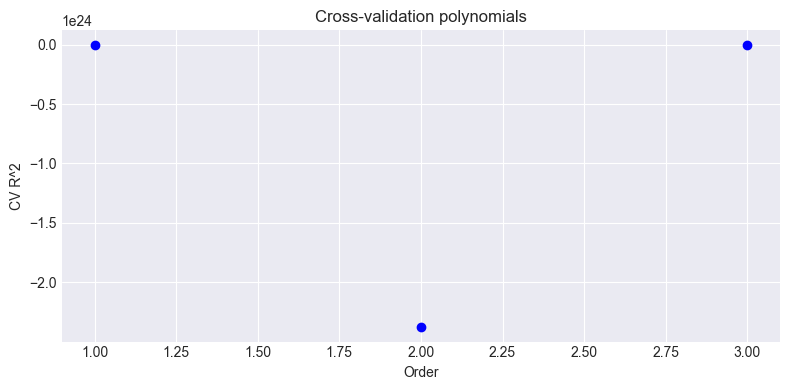

In [95]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [96]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 0


In [97]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])

reg_poly2.fit(X_train, y_train)
poly_train_res = reg_poly2.score(X_train, y_train)
poly_val_res = reg_poly2.score(X_val, y_val)

print(str(poly_train_res))
print(str(poly_val_res))

0.37019932504055186
0.3412946764620519


# K Nearest Neighbors

## Radius Neighbors Regression

cross validation from 15 to 25

In [98]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.model_selection import cross_val_score

Radius = np.linspace(15,25,40) # find peak R^2 from 40 calculated possibilities
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the 11 possible values for the radius (bandwith)
for k in Radius:
    Rnn = RadiusNeighborsRegressor(radius=k)
    scores = cross_val_score(Rnn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))   

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\neighbors\_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\model_selection\_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\metrics\_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Victo\.virtualenvs\SchoolProject-

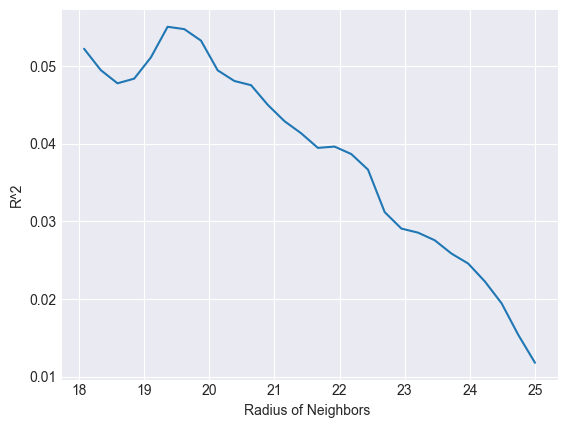

The best radius is 15.0


In [99]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(Radius, cv_scores)
plt.xlabel('Radius of Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best radius is', Radius[max_index])

We can clearly see that the R2 of the model drops after 18 as the radius increases. 
This is because our model becomes more and more underfitted. 

In [100]:
# getting the best radius and validation score

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

print('The best radius is', Radius[max_index])

# retraining and testing
rnn_best = RadiusNeighborsRegressor(radius=Radius[max_index])
rnn_best.fit(X_train_stand, y_train)
print(rnn_best.score(X_train_stand, y_train))
print(max_value)

The best radius is 15.0
0.04956863501932118
nan


results are very low, there is a very low possibility this model would be the right one.

## K-nearest Neighbors

cross validation

In [101]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,120)    
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwith)

for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

plot

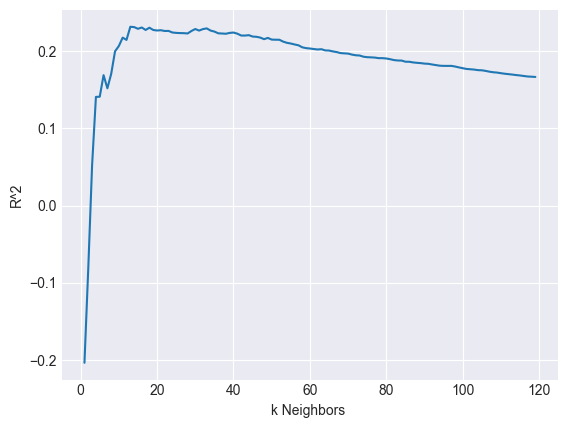

The best k is 13


In [102]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

This plot is hard to read, so lets focus on values 2 to 60, because using more than 30 neighbors clearly leads to underfitting

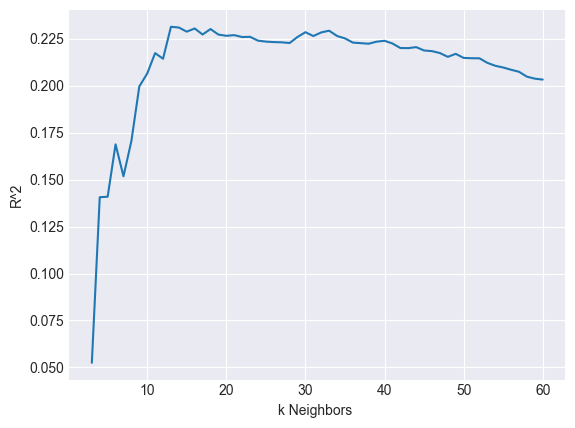

The best k is 13
The best validation score is 0.23134490783013453


In [103]:
plt.plot(K[2 : 60],cv_scores[2 :60])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])
print('The best validation score is', max_value)

The best k is 13, with a validation score of 0.26. This is rather low. Let's see if the model in underfitted.


In [104]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)

knn_train_res = knn.score(X_train_stand, y_train)
knn_val_res = knn.score(X_val_stand, y_val)

print(str(knn_train_res)) # result training dataset
print(str(knn_val_res)) # result validation dataset

0.35018587732410544
0.34309651531533236


This is also not that high, so there indeed might be underfitting

# Tree based

## Decision trees

cross validation

In [105]:
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import cross_val_score

depth = np.arange(1,50)    # This will give an array of numbers between 1 and 50
cv_scores = []
sd_scores = []

# perform 5-fold cross validation on the  possible values for the radius (bandwith)
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state = 0, max_depth=d)  
    scores = cross_val_score(dec_tree, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

plots

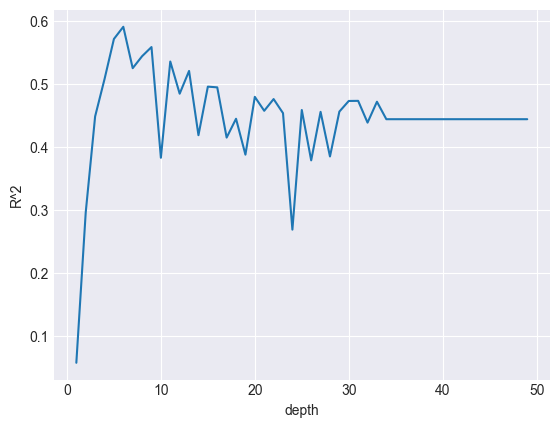

The best depth is 6


In [106]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth, cv_scores)
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])

Let's have a closer look

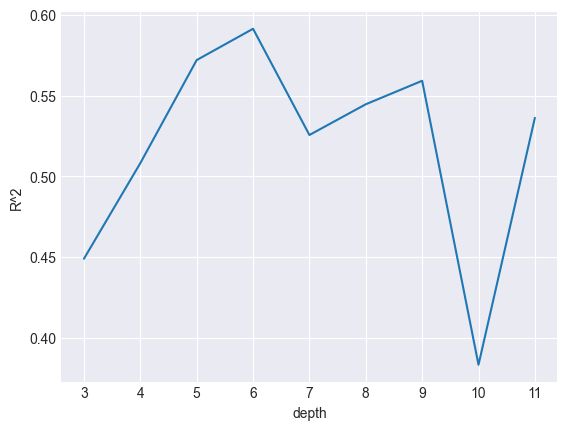

The best depth is 6
The best validation scorer is 0.5913854673247754


In [107]:
max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(depth[2:11], cv_scores[2:11])
plt.xlabel('depth')
plt.ylabel('R^2')

plt.show()
print('The best depth is', depth[max_index])
print('The best validation scorer is', max_value)

Retrain and test

In [108]:
from sklearn import tree  

dec_tree = DecisionTreeRegressor(random_state=0, max_depth=depth[max_index])
dec_tree.fit(X_train_stand, y_train) 

dt_train_res = dec_tree.score(X_train_stand, y_train) # score of training dataset
dt_val_res = dec_tree.score(X_val_stand, y_val) # score of validation dataset

print(str(dt_train_res))
print(str(dt_val_res))

0.8360976775657876
0.6461391168823817


## Random Forest

### random search

In [109]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 200)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 490)]

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes}

# then do cross-validatoin
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
rf_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [10, 11, 12, 13, 14,
                                                           15, 16, 17, 18, 19,
                                                           20, 21, 22, 23, 24,
                                                           25, 26, 27, 28, 29,
                                                           30, 31, 32, 33, 34,
                                                           35, 36, 37, 38, 39, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 102, 104, 106,
                                                         108, 110, 112, 114,
                                                         116, 118, 120, 122,
                                                         124, 126, 128, 130,
                                                         132, 134, 136, 138,
                                                         140, 142, 144, 146,
                                                         148, 150, 152, 154,
                                                         156, 158, ...]},
                   random_state=42, verbose=2)

Print out the training and validated $R^2$ for the best model from the random search 

In [110]:
print(rf_random.best_score_)

rf_train_res = rf_random.score(X_train_stand, y_train)
rf_val_res = rf_random.score(X_val_stand, y_val)

print(rf_train_res) #training dataset
print(rf_val_res) #validation dataset

0.6918673742252729
0.8057611692291364
0.7844096396093376


print out the parameters of the best model

In [111]:
rf_random.best_params_

{'n_estimators': 315,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 485,
 'max_features': 'auto',
 'max_depth': 6,
 'criterion': 'absolute_error'}

In [112]:
out = pd.DataFrame(rf_random.cv_results_)
out.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,207.397321,1.286291,0.117956,0.009589,385,7,14,90,auto,12,absolute_error,"{'n_estimators': 385, 'min_samples_split': 7, ...",0.509198,0.621835,0.626787,0.585940,0.054302,18
1,8.477884,0.694208,0.051984,0.006461,138,6,13,444,sqrt,6,absolute_error,"{'n_estimators': 138, 'min_samples_split': 6, ...",0.135359,0.259464,0.180046,0.191623,0.051323,82
2,0.937968,0.060661,0.059703,0.003732,128,12,4,148,log2,13,squared_error,"{'n_estimators': 128, 'min_samples_split': 12,...",0.303148,0.318938,0.341593,0.321226,0.015778,44
3,122.430836,3.155462,0.096609,0.007353,457,7,15,213,auto,2,absolute_error,"{'n_estimators': 457, 'min_samples_split': 7, ...",0.363081,0.414169,0.439778,0.405676,0.031882,30
4,16.510104,0.321757,0.074081,0.008090,274,12,8,191,sqrt,5,absolute_error,"{'n_estimators': 274, 'min_samples_split': 12,...",0.160515,0.244152,0.190261,0.198309,0.034615,80


Plot the results  for the hyperparameters

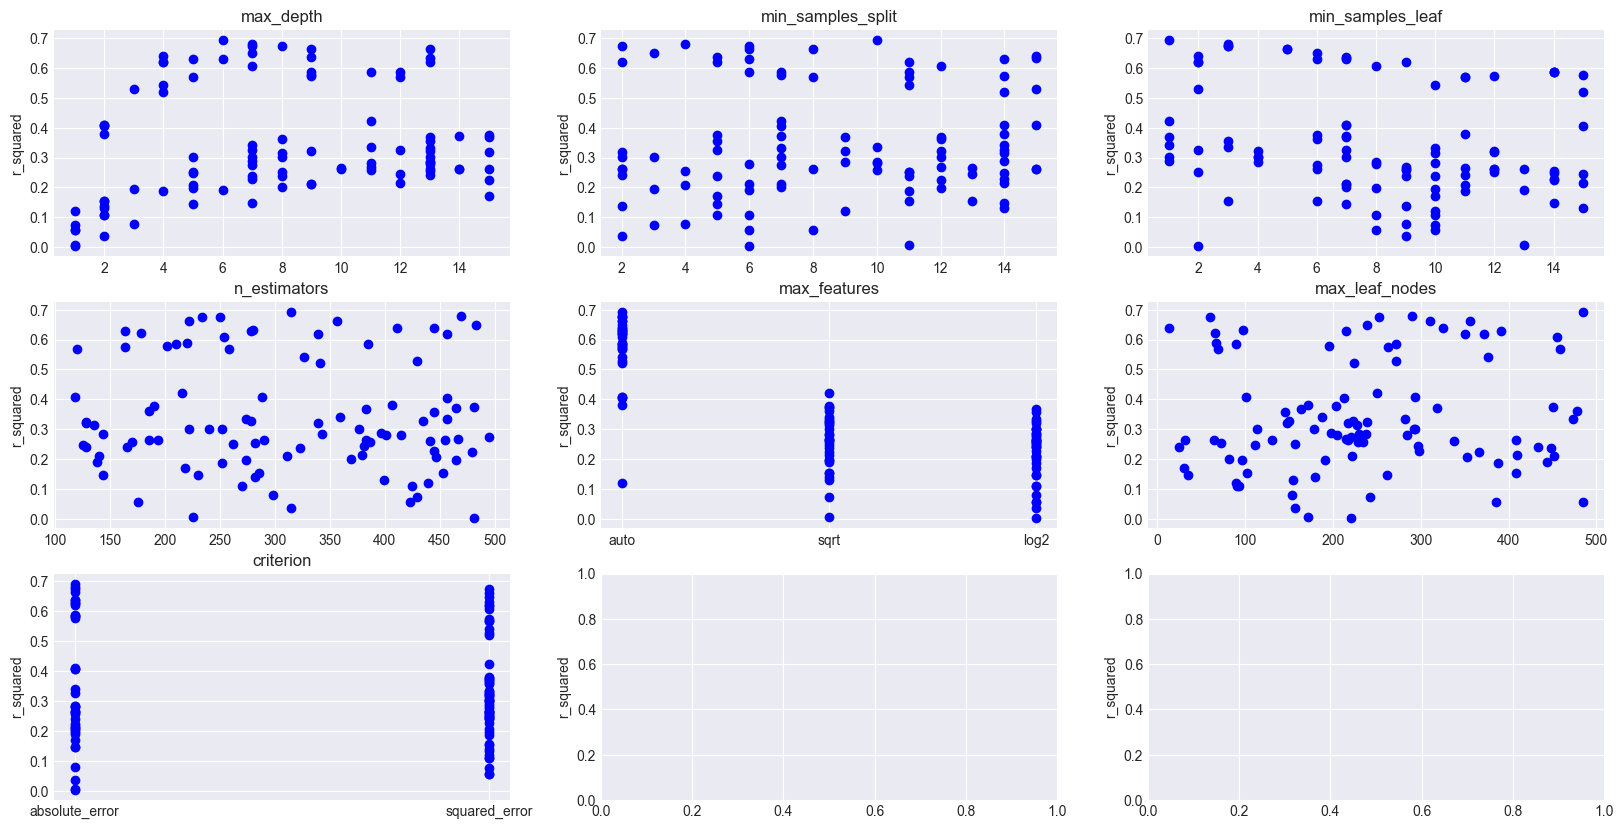

In [113]:
xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue');
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue');
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue');
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue');
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue');
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue');
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue');
axs[2,0].set_title('criterion')

for ax in axs.flat:
    ax.set(ylabel='r_squared')
    

### Max depth
We can see that the best depth is 6, but 7 and 13 do not perform much worse. However, we prefer models that are less complex. Here, that means models that are less deep. So, we chose 6 and 7 to go in the grid search.

### Min samples split
We can see that the best value is 10.

### Min samples leaf
1 leads to the best R^2, but 3 is not that much worse. We prefer a higher number of samples in a leaf (less complex), thus we include 1 and 3.

### n-estimators
The best value was with 315 trees.

### Max features
Auto clearly wins here, so let's just go with that.

### Max leaf nodes
The best max_leaf_nodes is 485, but around 300 is not much worse. Let's add 485 and 300 to the grid search.

### Criterion
mae had the best score,we use mae

### grid search

In [114]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315]
max_features = ['auto']
max_depth = [6,7]
min_samples_split = [10]
min_samples_leaf = [1,3]
max_leaf_nodes = [300, 485] 


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models  parallel as possible
rf_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 7],
                         'max_features': ['auto'], 'max_leaf_nodes': [300, 485],
                         'min_samples_leaf': [1, 3], 'min_samples_split': [10],
                         'n_estimators': [315]},
             verbose=2)

In [115]:
rf_grid.best_params_

{'criterion': 'absolute_error',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 485,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 315}

Not a lot has changed, this is not that unexpected, because we did not give a lot of options in the grid search.

In [116]:
print(rf_grid.best_score_)

rf_train_res = rf_grid.score(X_train_stand, y_train)
rf_val_res = rf_grid.score(X_val_stand, y_val)

print(str(rf_train_res))#training data
print(str(rf_val_res))#validation data

0.6713008633307913
0.8249366761903838
0.788598189680043


In [117]:
params = rf_grid.best_params_
rf_gridBest = RandomForestRegressor(**params)
rf_gridBest.fit(X_train_stand, y_train)

c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomForestRegressor(criterion='absolute_error', max_depth=7,
                      max_features='auto', max_leaf_nodes=485,
                      min_samples_split=10, n_estimators=315)

The random forest gives us the best model untill now.

# whitening the black box (interpret results easier)

### feature importance

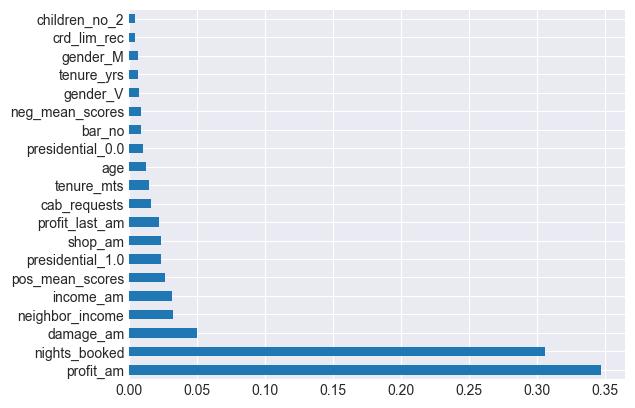

In [118]:
# Plot the 20 most important params

from matplotlib import pyplot as plt

plt.figure()

feat_importances = pd.Series(rf_gridBest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

So, the three features that seem to have the most influence in our algorithm are the profit amount, nights booked at the hotel and the amount of damage that was caused.

But what is the direction of this influence? Here, you might guess it from the context ( a person who booked more nights will give the hotel a higher profit), but be carefull with making assumptions like that. There is always a chance that you are wrong. So you have to check the directions of the influences yourself.

### Influence of each feature

get predictions from random forest

In [119]:
pred_train = rf_gridBest.predict(X_train_stand)

Perform one univariate linear regressions per feature on the predicted values!

In [120]:
from sklearn.linear_model import LinearRegression

X = pd.DataFrame(X_train_stand)
X.columns = X_train.columns
predictors =  X_train.columns
y = np.array((pred_train-pred_train.mean())/np.sqrt(pred_train.var())).reshape(-1, 1)

reg = LinearRegression().fit(X[[predictors[0]]], y)
beta = pd.Series(reg.coef_[0])
names = pd.Series(predictors[0])

for i in np.arange(1,(X.shape[1])):
    reg = LinearRegression().fit(X[[predictors[i]]], y)
    beta_help = pd.Series(reg.coef_[0])
    names_help = pd.Series(predictors[i])
    beta = pd.concat([beta,beta_help], axis=0)
    names = pd.concat([names,names_help], axis=0)

betas = pd.concat([names,beta],axis=1)
betas

,0,1
0,income_am,0.411060
0,profit_last_am,0.324535
0,profit_am,0.482471
0,damage_am,0.081649
0,crd_lim_rec,-0.097960
...,...,...
0,shop_use_Undefined,-0.088949
0,retired_0,-0.120259
0,retired_1,0.120259
0,gold_status_0,-0.878388


de lijst geeft hetzelfde weer zoals op de grafiek erboven. Zo kan je hier ook zien dat profit_am de belangrijkste feature is.

### Why is a prediction what it is? **lime doesn't work with python 3.11.1**

In [121]:
#import lime
#import lime.lime_tabular
#from lime.lime_tabular import LimeTabularExplainer


# creating the explainer function
#explainer = LimeTabularExplainer(X_train_stand.values, mode="regression", feature_names=X_train.columns)

# storing a new observation
#i = 100
#X_test_stand = pd.DataFrame(X_test_stand)
#X_test_stand.columns = X_train.columns

#X_observation = X_test_stand.iloc[[i], :]

In [122]:
# explanation using the random forest model
# explanation = explainer.explain_instance(X_observation.values[0], rf_gridBest.predict)
# explanation.show_in_notebook(show_table=True, show_all=False)

# Gradient boosting machine

random search

In [123]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

criterion =['squared_error','absolute_error']
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(1, 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(2, 15, num = 14)]
min_samples_leaf = [int(x) for x in np.linspace(1, 15, num = 15)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 500, num = 50)]
loss = ['ls','lad','huber','quantile'] # see pwp 
learning_rate = [round(x,5) for x in np.linspace(0.1, 1, num = 10)] # see pwp default

# create the random grid to search for best hyperparameters
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes,
               'loss': loss,
               'learning_rate': learning_rate}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions = random_grid, n_iter = 100, 
                               cv = 3, verbose=2, random_state=42, n_jobs=-1)

gbm_random.fit(X_train_stand, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
237 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
51 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_gb.py", line 420, in fit
    self._validate_params()
  File "c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\base.py", line 600, in 

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1.0],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'max_leaf_node...
                                                           150, 160, 170, 180,
                                                           190, 200, 210, 220,
                                                           230, 240, 250, 260,
                                                           270, 280, 290, 300, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 11, 12,
                                                              13, 14, 15],
                                        'n_estimators': [100, 108, 116, 124,
                                                         132, 140, 148, 157,
                                                         165, 173, 181, 189,
                                                         197, 206, 214, 222,
                                                         230, 238, 246, 255,
                                                         263, 271, 279, 287,
                                                         295, 304, 312, 320,
                                                         328, 336, ...]},
                   random_state=42, verbose=2)

Print out the validated $R^2$ for the best model from the random search 

In [124]:
print(gbm_random.best_score_)


print(gbm_random.score(X_train_stand, y_train)) #training data
print(gbm_random.score(X_val_stand, y_val)) #validation data

0.6637703425997296
0.855373247587639
0.7693910358985742


In [125]:
gbm_random.best_params_

{'n_estimators': 189,
 'min_samples_split': 7,
 'min_samples_leaf': 15,
 'max_leaf_nodes': 260,
 'max_features': 'auto',
 'max_depth': 7,
 'loss': 'huber',
 'learning_rate': 0.1,
 'criterion': 'squared_error'}

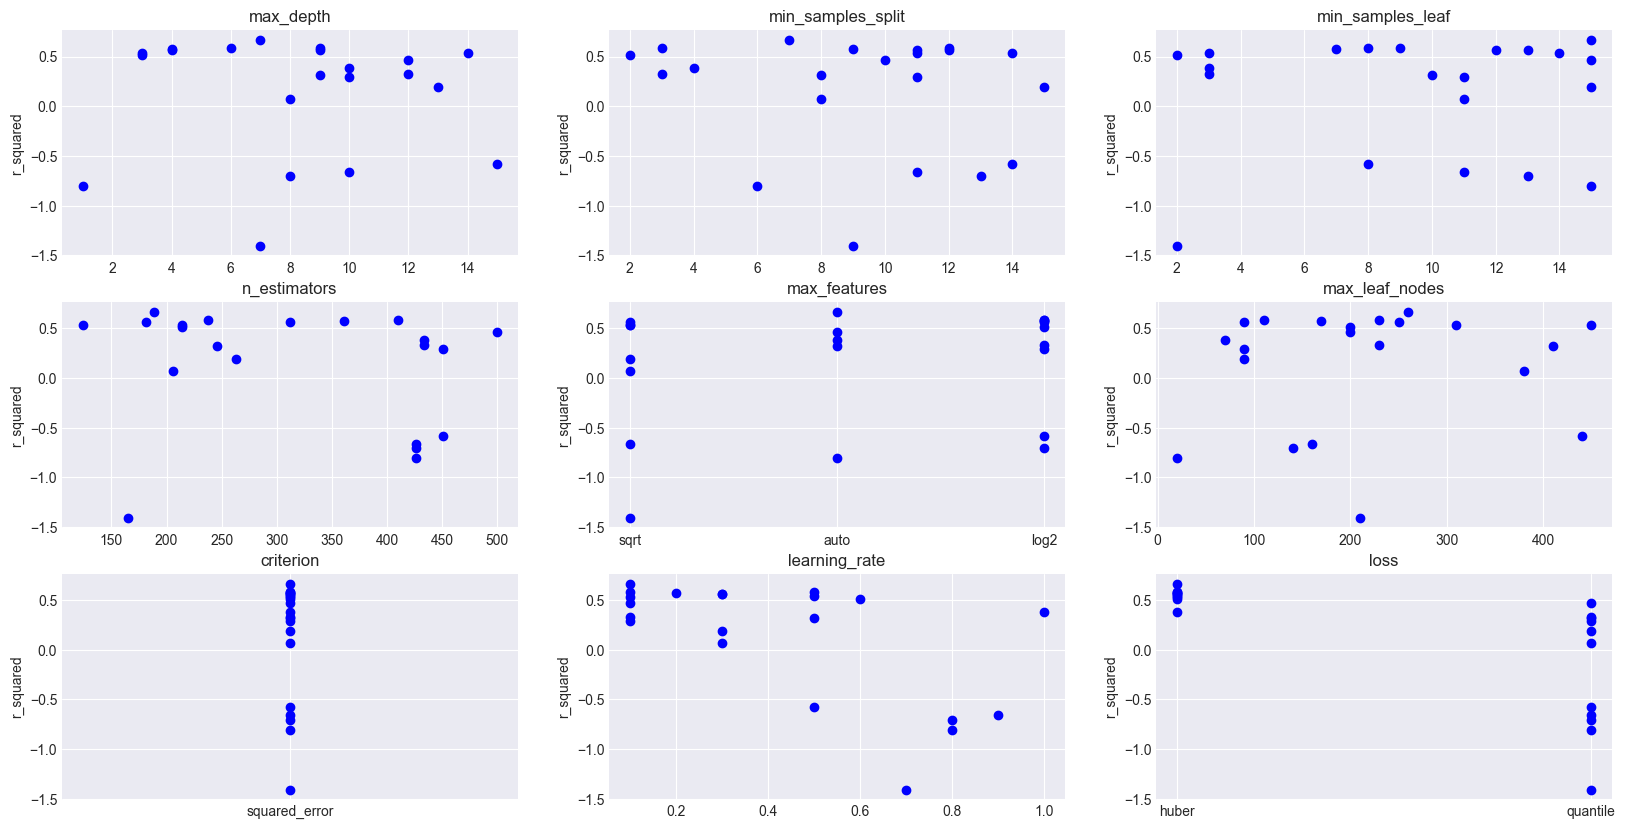

In [126]:
# plotting out the results of the hyperparameters

out = pd.DataFrame(gbm_random.cv_results_)

xlabel_names = ['param_max_depth','param_min_samples_split','param_min_samples_leaf','param_n_estimators',
                'param_max_features', 'param_max_leaf_nodes', 'param_criterion']

fig, axs = plt.subplots(3,3, figsize=(20,10))

axs[0,0].scatter(out['param_max_depth'], out['mean_test_score'], c='blue')
axs[0,0].set_title('max_depth')

axs[0,1].scatter(out['param_min_samples_split'], out['mean_test_score'], c='blue')
axs[0,1].set_title('min_samples_split')

axs[0,2].scatter(out['param_min_samples_leaf'], out['mean_test_score'], c='blue')
axs[0,2].set_title('min_samples_leaf')

axs[1,0].scatter(out['param_n_estimators'], out['mean_test_score'], c='blue')
axs[1,0].set_title('n_estimators')

axs[1,1].scatter(out['param_max_features'], out['mean_test_score'], c='blue')
axs[1,1].set_title('max_features')

axs[1,2].scatter(out['param_max_leaf_nodes'], out['mean_test_score'], c='blue')
axs[1,2].set_title('max_leaf_nodes')

axs[2,0].scatter(out['param_criterion'], out['mean_test_score'], c='blue')
axs[2,0].set_title('criterion')

axs[2,1].scatter(out['param_learning_rate'], out['mean_test_score'], c='blue')
axs[2,1].set_title('learning_rate')

axs[2,2].scatter(out['param_loss'], out['mean_test_score'], c='blue')
axs[2,2].set_title('loss')


for ax in axs.flat: ax.set(ylabel='r_squared')

lets tune the hyperparameters of the model a bit further with grid search

### grid search

In [127]:
from sklearn.model_selection import GridSearchCV

criterion =['squared_error']
n_estimators = [189]
max_features = ['auto']
max_depth = [7]
min_samples_split = [7]
min_samples_leaf = [15]
max_leaf_nodes = [260]
learning_rate = [0.1]
loss = ['huber']

# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            'max_leaf_nodes': max_leaf_nodes,
               'learning_rate': learning_rate,
               'loss':loss}

# then do cross-validation
gbm = GradientBoostingRegressor()
gbm_grid = GridSearchCV(estimator = gbm, param_grid = grid, cv = 5, verbose=2,  n_jobs=-1)
# n_jobs=-1 to run as many models  parallel as possible
gbm_grid.fit(X_train_stand, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed i

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error'], 'learning_rate': [0.1],
                         'loss': ['huber'], 'max_depth': [7],
                         'max_features': ['auto'], 'max_leaf_nodes': [260],
                         'min_samples_leaf': [15], 'min_samples_split': [7],
                         'n_estimators': [189]},
             verbose=2)

In [128]:
gbm_grid.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.1,
 'loss': 'huber',
 'max_depth': 7,
 'max_features': 'auto',
 'max_leaf_nodes': 260,
 'min_samples_leaf': 15,
 'min_samples_split': 7,
 'n_estimators': 189}

In [129]:
print(gbm_grid.best_score_)

gb_train_res = gbm_grid.score(X_train_stand, y_train)
gb_val_res = gbm_grid.score(X_val_stand, y_val)

print(gb_train_res) #training data
print(gb_val_res) #validation data

0.6706775855757436
0.8525716827475454
0.7578887450561969


# Evaluation

In [130]:
# This code creates a table with the type of model and training and validation data. This is to ensure that each new change the evaluation is updated automatically.

from IPython.display import Markdown as md

table_template = "|Model|Train|Validation|\n| --- | --- | --- |\n|PolynomialRegressor|{poly_train:.1%}|{poly_val:.1%}|\n|KNearestNeighbor|{knn_train:.1%}|{knn_val:.1%}|\n|DecisionTree|{dt_train:.1%}|{dt_val:.1%}|\n|RandomForestRegressor|{rf_train:.1%}|{rf_val:.1%}|\n|GradientBoostingRegressor|{gb_train:.1%}|{gb_val:.1%}|"


md(table_template.format(poly_train=poly_train_res, poly_val=poly_val_res, knn_train=knn_train_res, knn_val=knn_val_res, dt_train=dt_train_res, dt_val=dt_val_res, rf_train=rf_train_res, rf_val=rf_val_res, gb_train=gb_train_res, gb_val=gb_val_res))

|Model|Train|Validation|
| --- | --- | --- |
|PolynomialRegressor|37.0%|34.1%|
|KNearestNeighbor|35.0%|34.3%|
|DecisionTree|83.6%|64.6%|
|RandomForestRegressor|82.5%|78.9%|
|GradientBoostingRegressor|85.3%|75.8%|

# Fit and predict on the best model (RandomForestRegressor)

In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

criterion =['absolute_error']
n_estimators = [315]
max_features = ['auto']
max_depth = [6,7]
min_samples_split = [10]
min_samples_leaf = [1,3]
max_leaf_nodes = [300, 485] 


# create the random grid to search for best hyperparameters
grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
                'max_leaf_nodes': max_leaf_nodes,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

# then do cross-validation
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator=rf, param_grid=grid, cv=5,verbose=2, n_jobs=-1)

# n_jobs=-1 to run as many models parallel as possible

rf_grid.fit(X_val_stand, y_val) # fit on validation

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\Victo\.virtualenvs\SchoolProject-jfK-57_F\Lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'], 'max_depth': [6, 7],
                         'max_features': ['auto'], 'max_leaf_nodes': [300, 485],
                         'min_samples_leaf': [1, 3], 'min_samples_split': [10],
                         'n_estimators': [315]},
             verbose=2)

## add predicted outcome_profit to csv file

In [132]:
df_scores = pd.read_csv('score_cleaned.csv')

print(rf_grid.score(X_test_stand, y_test))

# if the columns exists, remove it. This is to ensure when rerunning this cel, it doesn't break

if "outcome_profit" in df_scores.columns:
	df_scores.drop("outcome_profit", axis=1, inplace=True)

# if the column doesn't exist, perform the prediction and add the result to the column

if "outcome_profit" not in df_scores.columns:

	# predict on the fitted model
	y_pred = rf_grid.predict(X_test_stand)


	# create the column 'outcome_profit' and set the contents to the prediction
	# y_pred for some reason has 900+ extra rows, so I will only take the first 496 that are created.
	# python -> excel will not use the '.' as a comma, so it will take for example 1907.123456 and change it to 1907123456, which is not what we want.

	formatted_numbers = [(round(n, 2)) for n in y_pred[:496]]
	
	# formatting the floats to have only 2 decimals and then changing the type to float64 does the job
	df_scores["outcome_profit"] = formatted_numbers
	df_scores["outcome_profit"] = df_scores["outcome_profit"].astype(np.float64)
	df_scores.to_csv('score_cleaned.csv', index=False)

0.5983416774831722
